In [2]:
import math, random
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd 
import torch.nn.functional as F
from collections import deque

from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

modified from https://github.com/higgsfield/RL-Adventure/blob/master/1.dqn.ipynb

In [3]:
# use GPU if available
USE_CUDA = torch.cuda.is_available()
Variable = lambda *args, **kwargs: autograd.Variable(*args, **kwargs).cuda() if USE_CUDA else autograd.Variable(*args, **kwargs)

In [13]:
class ReplayBuffer(object):
    ''' buffer to hold and sample (state, action, reward, next state) tuples'''
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, state, action, reward, next_state, done):
        '''add tuple for state transition'''
        state      = np.expand_dims(state, 0)
        next_state = np.expand_dims(next_state, 0)
            
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        '''sample uniformly from buffer'''
        state, action, reward, next_state, done = zip(*random.sample(self.buffer, batch_size))
        return np.concatenate(state), action, reward, np.concatenate(next_state), done
    
    def __len__(self):
        '''return current length of buffer'''
        return len(self.buffer)

In [14]:
def compute_td_loss(batch_size):
    '''compute TD(0) loss for batch_size number of samples'''
    # sample uniformly from buffer of previous state action tuples
    state, action, reward, next_state, done = replay_buffer.sample(batch_size)
    
    # convert to torch
    state      = Variable(torch.FloatTensor(np.float32(state)))
    with torch.no_grad():
        next_state = Variable(torch.FloatTensor(np.float32(next_state)))
    action     = Variable(torch.LongTensor(action))
    reward     = Variable(torch.FloatTensor(reward))
    done       = Variable(torch.FloatTensor(done))

    # forward pass for Q-value for state and next_state
    q_values      = model.forward(state)
    next_q_values = model.forward(next_state)
    
    # get Q- value of action taken
    q_value          = q_values.gather(1, action.unsqueeze(1)).squeeze(1)
    # max over next actions
    next_q_value     = next_q_values.max(1)[0]
    # discounted expected future rewards
    expected_q_value = reward + gamma * next_q_value * (1 - done)
    
    # squared TD error
    loss = (q_value - Variable(expected_q_value.data)).pow(2).mean()
        
    # backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return loss

In [6]:
def plot(frame_idx, rewards, losses):
    '''plot intermediate results'''
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, np.mean(rewards[-10:])))
    plt.plot(rewards)
    plt.subplot(132)
    plt.title('loss')
    plt.plot(losses)
    plt.show()

In [7]:
class one_hot_hand_target:
    '''agent class. Hand and cursor are one hot pixels in separate inputs channels'''
    def __init__(self,npixelx,npixely,king_moves=False):
        self.hand_set = False # bool whether hand is placed
        self.target_set = False # bool whether target is placed
        self.npixelx = npixelx # # size of screen in x
        self.npixely = npixely # size of screen in y 
        self.observation_shape = [2,npixelx,npixely] # shape of inputs
        self.target_radius = 1 # pixel radius considered as reaching the target 
        
        
        # encode hand state as one hot matrix - leave empty 
        self.hand = None 
        
        # encode target state - leave empty until target is placed
        self.target = None 
        
        
        if king_moves: # allow diagonal moves
            self.num_actions = 8
            self.actions = np.array([[1,0],
                           [0,1],
                           [-1,0],
                           [0,-1],
                           [1,1],
                           [1,-1],
                           [-1,1],
                           [-1,-1]])
        else:
            self.num_actions = 4
            self.actions = np.array([[1,0],
                           [0,1],
                           [-1,0],
                           [0,-1]])
            
    def place_hand(self,x,y):
        self.hand = np.array([x,y])
        self.hand_set=True
        
        
    def place_target(self,x,y):
        self.target = np.array([x,y])
        self.target_set = True
        
        
    def init_trial(self,hx,hy,tx,ty):
        # place hand
        self.place_hand(hx,hy)
        
        # place target
        self.place_target(tx,ty)
        
        
        # calculate reward
        reward = self.get_reward()
        if reward>-1:
          return self.get_state(),0,True
        else:
          return self.get_state(),-1,False
        
    def get_reward(self):
        if np.linalg.norm(self.target-self.hand,2)<=self.target_radius:
          return 0
        else:
          return -1
        

    def get_state(self):
        screen = np.zeros((2,self.npixelx,self.npixely))
        screen[0,self.hand[0],self.hand[1]]+=10
        screen[1,self.target[0],self.target[1]]+=10
        
        return screen 
    
    
    def step(self,a):

        action = self.actions[a,:]
        self.hand[0]= np.minimum(np.maximum(self.hand[0]+action[0],0),self.npixelx-1)
        self.hand[1]= np.minimum(np.maximum(self.hand[1]+action[1],0),self.npixely-1)
        
        
        reward = self.get_reward()
        if reward>-1:
          return self.get_state(),0,True
        else:
          return self.get_state(),-1,False
        

In [8]:
class CnnDQN(nn.Module):
    ''' Deep Q-Network from pixels '''
    def __init__(self, input_shape, num_actions):
        super(CnnDQN, self).__init__()
        
        self.input_shape = input_shape
        self.num_actions = num_actions
        

#         # 64 x 64 settings - doesn't quite work yet, exploding gradients, loss divergerges at later stages of training
#         self.features = nn.Sequential(
#             nn.Conv2d(input_shape[0], 2, kernel_size=5, stride=1),
#             nn.ReLU(),
#             nn.Conv2d(2, 4, kernel_size=5, stride=1),
#             nn.ReLU(),
#             # nn.Conv2d(8, 32, kernel_size=1, stride=1),
#             # nn.ReLU()
#         )
# #         print(self.features)
#         self.fc = nn.Sequential(
#             nn.Linear(self.feature_size(), 64),
#             nn.ReLU(),
#             # nn.Dropout(p=0),
#             nn.Linear(64,64),
#             nn.ReLU(),
#             nn.Linear(64, self.num_actions),
#         )

        # 16 x 16 solution
        self.features = nn.Sequential(
            nn.Conv2d(input_shape[0], 8, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Conv2d(8, 16, kernel_size=3, stride=1),
            nn.ReLU(),
        )
        self.fc = nn.Sequential(
            nn.Linear(self.feature_size(), 128),
            nn.ReLU(),
            nn.Dropout(p=.3), # this layer doesn't seem terribly important
            nn.Linear(128,128),
            nn.ReLU(),
            nn.Linear(128, self.num_actions)
        )
        

    def forward(self, x): 
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x
    
    def feature_size(self):
        return self.features(autograd.Variable(torch.zeros(1, *self.input_shape))).view(1, -1).size(1)
    
    def act(self, state, epsilon):
        '''epsilon greedy behavior'''
        if random.random() > epsilon: # get action with highest Q-value
            with torch.no_grad():
                state   = Variable(torch.FloatTensor(np.float32(state)).unsqueeze(0))
            q_value = self.forward(state)
            action  = torch.argmax(torch.squeeze(q_value)).item() 
        else: # behave randomly
            action = random.randrange(self.num_actions)
        return action

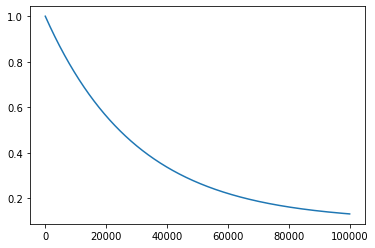

In [10]:
# parameters for controlling epsilon-greedy behavior
epsilon_start = 1
epsilon_final = 0.1
epsilon_decay = 30000

epsilon_by_frame = lambda frame_idx: epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. * frame_idx / epsilon_decay)
plt.plot([epsilon_by_frame(i) for i in range(100000)])

In [12]:


replay_initial = 1000 # frame for first replay batch
replay_buffer = ReplayBuffer(100000) # initialize replay buffer

num_frames = 100000 # number of total frames 
batch_size = 32 # number of samples to take in replay cycle
gamma      = 1. # discounting factor
npix = 16  # size of screen

losses = [] # initialize losses
all_rewards = [] # initialize rewards per episode
episode_reward = 0 # initialize reward counter
max_episode_length=100000 # when to quit an episode
episode_length = 0 # counter to check against max_episode_length
episode = 0 # episode counter
epsilon_counter = 0 # index for tracking epsilon (randomness of behavior)

h = one_hot_hand_target(npix,npix,king_moves=True) # initialize agent
h.target_radius = 8 # start with wide radius to speed up learning
model = CnnDQN(h.observation_shape, h.num_actions) # initialize model

# push model to GPU
if USE_CUDA:
    model = model.cuda()
    
# init optimizer
optimizer = optim.Adam(model.parameters(),lr=1E-3)

# place target and initialize trial
target_loc = [np.random.randint(npix),np.random.randint(npix)]
state,_,reward = h.init_trial(np.random.randint(npix),np.random.randint(npix),*target_loc)

for frame_idx in range(1,num_frames + 1):
    epsilon = epsilon_by_episode(epsilon_counter) # set randomnesss of actions
    action = model.act(state, epsilon) 
    next_state, reward, done = h.step(action)
    if reward==0: # print when trial is successfully finished, for debugging mostly
        print(reward)
    replay_buffer.push(state, action, reward, next_state, done) # add to buffer
    
    # update state and counters
    state = next_state
    episode_reward += reward
    episode_length+=1
    epsilon_counter+=1
    
    # if episode is complete, or the trial is stuck
    if done or (episode_length>max_episode_length):
        episode+=1 
        episode_length=0
        all_rewards.append(episode_reward)
        episode_reward = 0
        # if successfully performed 1000 episodes, decrease target radius
        if episode%1000==0:
            h.target_radius = np.maximum(h.target_radius/2,1)
            epsilon_counter=0
            
            
        # initialize new trial
        target_loc = [np.random.randint(npix),np.random.randint(npix)]
        # ensure hand is not within target radius of target to start
        done=True
        while done:
          state , _, done = h.init_trial(np.random.randint(npix),np.random.randint(npix),*target_loc)
        
    # calculate TD(0) loss and perform backprop
    if len(replay_buffer) > replay_initial:
        loss = compute_td_loss(batch_size) 
        losses.append(loss.item())
        
    # plot intermediate results
    if frame_idx % 1000 == 0:
        plot(frame_idx, all_rewards[-10000:], losses[-10000:])

[2, 16, 16]
0
0
0
0
0
0


KeyboardInterrupt: 

In [ ]:
torch.save(model,"DQN_16x16.pt")